In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn imbalanced-learn

IMPROVED STOCK MARKET CRASH PREDICTION SYSTEM
✓ Output directories created

LOADING DATASET
✓ Loaded dataset: (9052, 36)
✓ Date range: 1990-01-02 00:00:00 to 2025-12-09 00:00:00

DEFINING CRASH EVENTS (EARLY WARNING SYSTEM)
✓ Crash events detected: 1202 (13.31%)

Sample early warnings (20 days before crash):
  1. 1990-01-02: 20d=-10.21%, worst 5d=-4.75%
  2. 1990-01-03: 20d=-8.27%, worst 5d=-4.75%
  3. 1990-01-04: 20d=-7.56%, worst 5d=-4.75%
  4. 1990-07-09: 20d=-6.98%, worst 5d=-5.94%
  5. 1990-07-10: 20d=-6.08%, worst 5d=-5.99%

ADVANCED FEATURE ENGINEERING
✓ Advanced features created

FEATURE SELECTION
✓ Using 32 high-priority features
✓ Clean dataset: 7253 rows (1779 dropped)
✓ Crash events: 1153 (15.90%)
✓ Date range: 1997-01-14 to 2025-11-10

TRAIN/TEST SPLIT
✓ Training: 5802 samples, 904.0 crashes (15.58%)
✓ Test: 1451 samples, 249.0 crashes (17.16%)

ADVANCED RESAMPLING (SMOTE)
✓ SMOTE-Tomek applied
✓ Balanced training set: 9722 samples, 4861.0 crashes (50.00%)

FEATURE SCALING

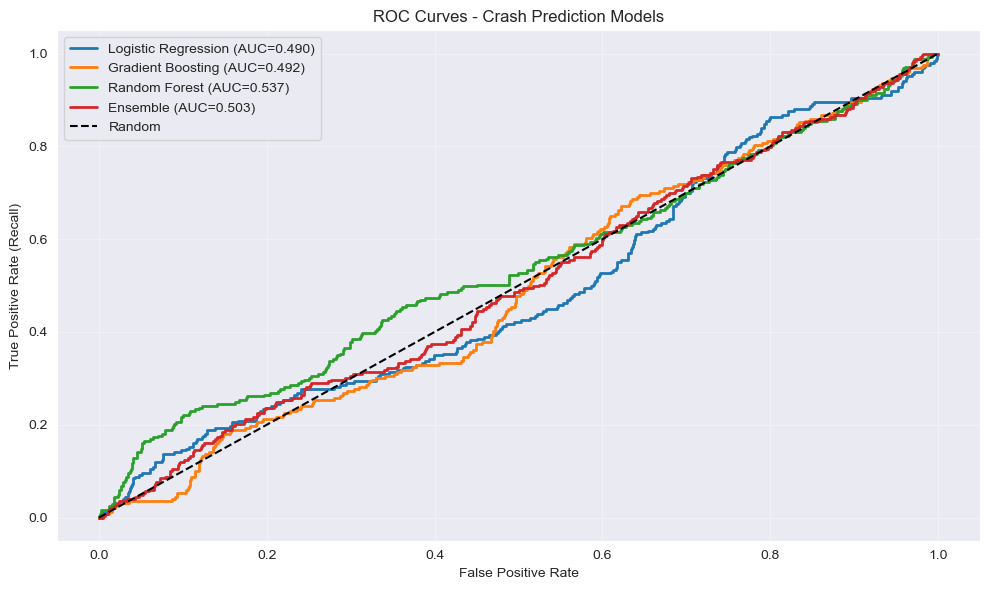

✓ ROC curves saved


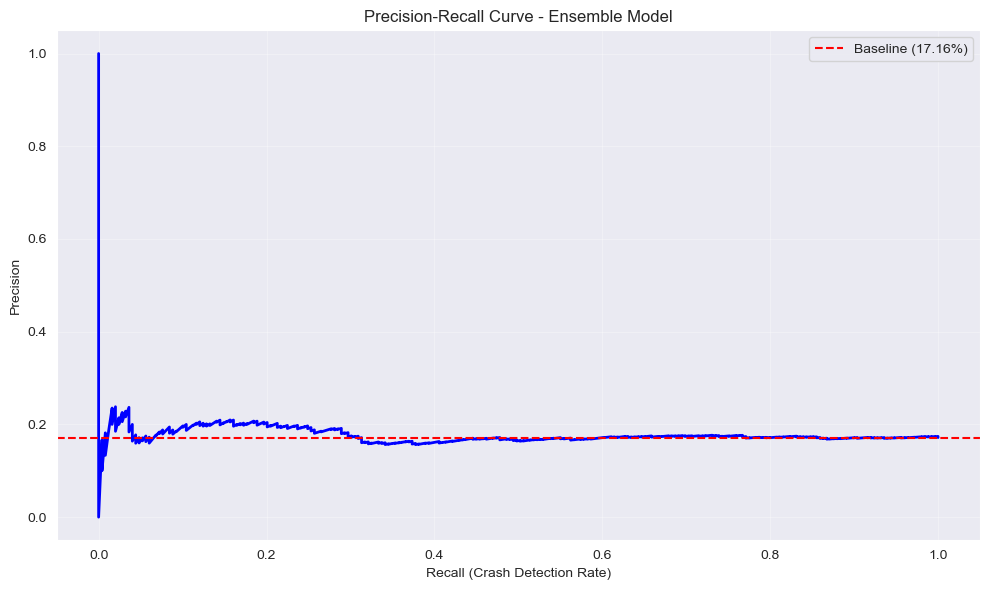

✓ Precision-Recall curve saved


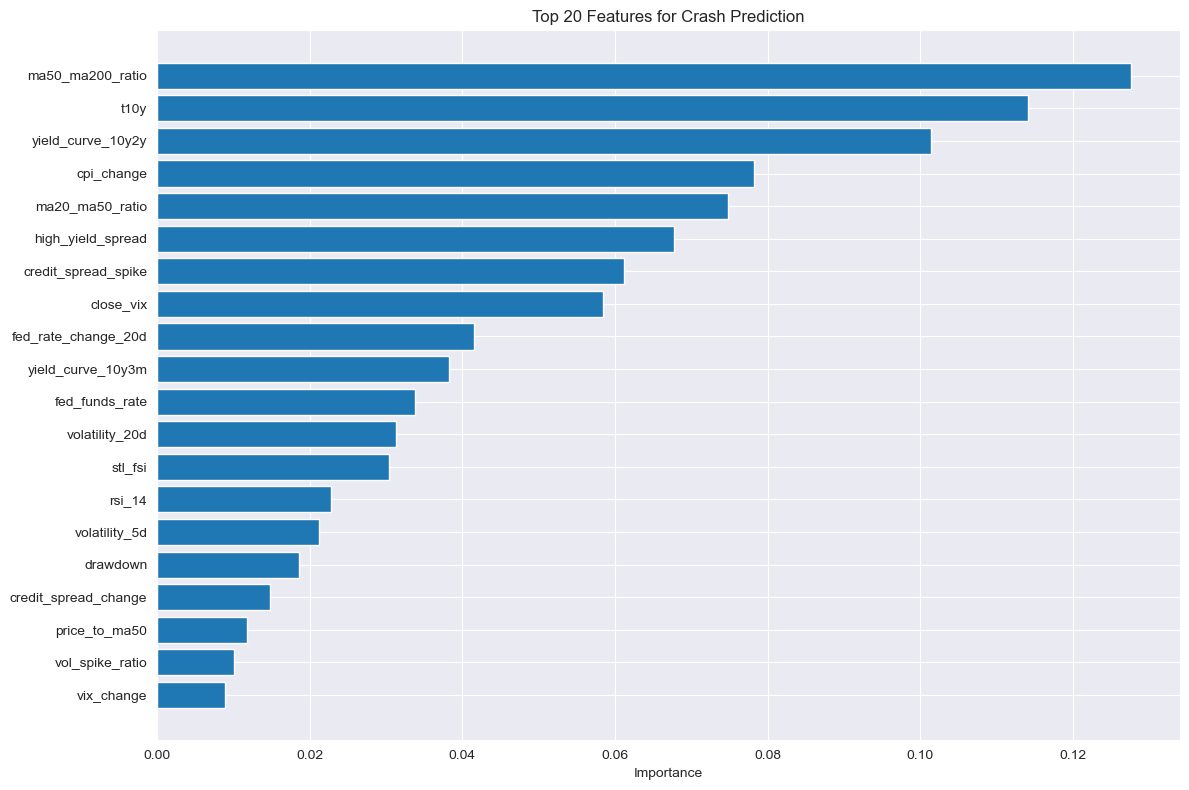

✓ Feature importance saved


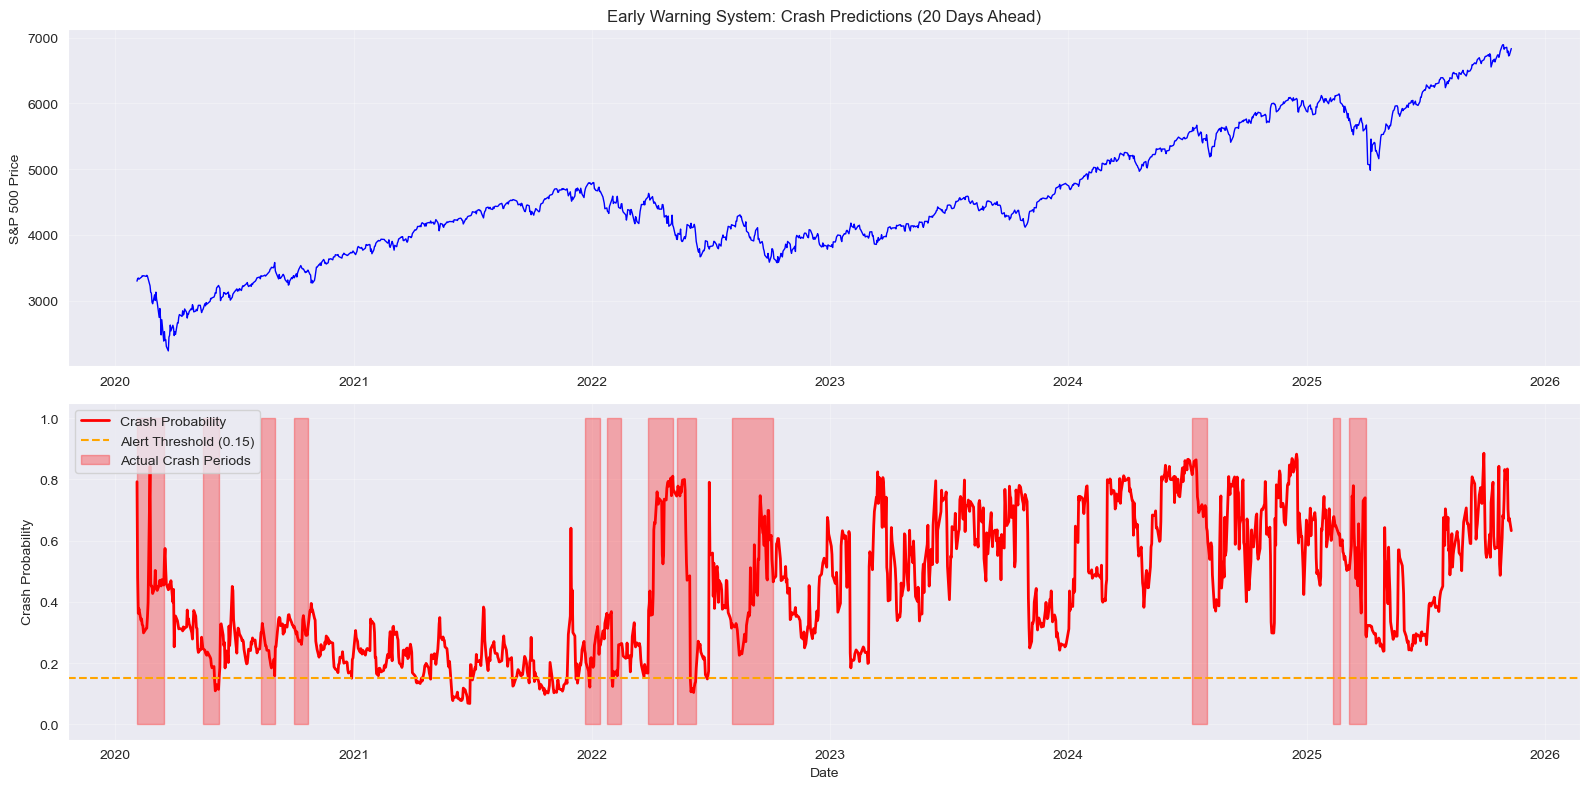

✓ Timeline saved

SAVING RESULTS
✓ Results: C:\Users\dmitr\Desktop\Stock-Market-Crash-Predictor\output\crash_predictions_improved.csv
✓ Models: C:\Users\dmitr\Desktop\Stock-Market-Crash-Predictor\output\models


In [15]:
# ============================================================================
# IMPROVED PREDICTIVE MODELING FOR STOCK MARKET CRASH DETECTION
# ============================================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, f1_score, recall_score, precision_score
)
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import warnings
warnings.filterwarnings('ignore')

# Set styling for plots
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

# ============================================================================
# STEP 0: DEFINE PATHS
# ============================================================================

print("=" * 80)
print("IMPROVED STOCK MARKET CRASH PREDICTION SYSTEM")
print("=" * 80)

BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, 'data')
MERGED_DIR = os.path.join(DATA_DIR, 'merged')
MERGED_FILE = os.path.join(MERGED_DIR, 'merged_dataset_cleaned.csv')

OUTPUT_DIR = os.path.join(BASE_DIR, 'output')
MODELS_DIR = os.path.join(OUTPUT_DIR, 'models')
PLOTS_DIR = os.path.join(OUTPUT_DIR, 'plots')

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

print(f"✓ Output directories created")

if not os.path.exists(MERGED_FILE):
    print(f"\n⚠️  ERROR: File not found at {MERGED_FILE}")
    exit(1)

# ============================================================================
# STEP 1: LOAD DATA
# ============================================================================

print("\n" + "=" * 80)
print("LOADING DATASET")
print("=" * 80)

df = pd.read_csv(MERGED_FILE)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

print(f"✓ Loaded dataset: {df.shape}")
print(f"✓ Date range: {df['date'].min()} to {df['date'].max()}")

# ============================================================================
# STEP 2: IMPROVED CRASH DETECTION
# ============================================================================

print("\n" + "=" * 80)
print("DEFINING CRASH EVENTS (EARLY WARNING SYSTEM)")
print("=" * 80)

# Calculate returns
df['sp500_return'] = df['close_sp500'].pct_change()

# Define crash with LONGER lead time (20 days instead of 10)
# This gives us more time to react
def detect_crash_forward(df, window=20, threshold=-0.07):
    """
    Detect if a crash occurs in the next `window` days
    EARLY WARNING: Predicts 20 days ahead instead of 10
    """
    crashes = []
    crash_details = []
    
    for i in range(len(df)):
        if i + window >= len(df):
            crashes.append(np.nan)
            continue
        
        future_returns = df['sp500_return'].iloc[i+1:i+1+window]
        cumulative_return = (1 + future_returns).prod() - 1
        
        # Also check for sharp drops in ANY 5-day period within the window
        max_drop_5d = 0
        for j in range(len(future_returns) - 4):
            five_day_return = (1 + future_returns.iloc[j:j+5]).prod() - 1
            max_drop_5d = min(max_drop_5d, five_day_return)
        
        # Crash if either: 20-day drop OR severe 5-day drop
        if cumulative_return <= threshold or max_drop_5d <= -0.05:
            crashes.append(1)
            if len(crash_details) < 10:
                crash_details.append({
                    'date': df['date'].iloc[i],
                    'cumulative_return': cumulative_return,
                    'worst_5d': max_drop_5d
                })
        else:
            crashes.append(0)
    
    return crashes, crash_details

# Use 7% threshold with 20-day window
df['crash_20d'], crash_details = detect_crash_forward(df, window=20, threshold=-0.07)
df_model = df[df['crash_20d'].notna()].copy()

print(f"✓ Crash events detected: {int(df_model['crash_20d'].sum())} ({df_model['crash_20d'].mean():.2%})")
print(f"\nSample early warnings (20 days before crash):")
for i, detail in enumerate(crash_details[:5]):
    print(f"  {i+1}. {detail['date'].strftime('%Y-%m-%d')}: 20d={detail['cumulative_return']:.2%}, worst 5d={detail['worst_5d']:.2%}")

# ============================================================================
# STEP 3: ADVANCED FEATURE ENGINEERING
# ============================================================================

print("\n" + "=" * 80)
print("ADVANCED FEATURE ENGINEERING")
print("=" * 80)

# 1. PRICE & TREND FEATURES
df_model['ma_10'] = df_model['close_sp500'].rolling(10, min_periods=5).mean()
df_model['ma_20'] = df_model['close_sp500'].rolling(20, min_periods=10).mean()
df_model['ma_50'] = df_model['close_sp500'].rolling(50, min_periods=25).mean()
df_model['ma_200'] = df_model['close_sp500'].rolling(200, min_periods=100).mean()

df_model['price_to_ma10'] = df_model['close_sp500'] / df_model['ma_10']
df_model['price_to_ma20'] = df_model['close_sp500'] / df_model['ma_20']
df_model['price_to_ma50'] = df_model['close_sp500'] / df_model['ma_50']
df_model['price_to_ma200'] = df_model['close_sp500'] / df_model['ma_200']

# Death cross / golden cross signals
df_model['ma20_ma50_ratio'] = df_model['ma_20'] / df_model['ma_50']
df_model['ma50_ma200_ratio'] = df_model['ma_50'] / df_model['ma_200']

# 2. VOLATILITY FEATURES (Critical for crash prediction!)
df_model['volatility_5d'] = df_model['sp500_return'].rolling(5, min_periods=3).std()
df_model['volatility_20d'] = df_model['sp500_return'].rolling(20, min_periods=10).std()
df_model['volatility_60d'] = df_model['sp500_return'].rolling(60, min_periods=30).std()

# Volatility spike (sudden increase in volatility)
df_model['vol_spike_ratio'] = df_model['volatility_5d'] / df_model['volatility_60d']

# 3. MOMENTUM FEATURES
df_model['momentum_5'] = df_model['close_sp500'].pct_change(periods=5)
df_model['momentum_10'] = df_model['close_sp500'].pct_change(periods=10)
df_model['momentum_20'] = df_model['close_sp500'].pct_change(periods=20)
df_model['momentum_60'] = df_model['close_sp500'].pct_change(periods=60)

# Rate of change in momentum (acceleration)
df_model['momentum_acceleration'] = df_model['momentum_5'].diff(5)

# 4. VIX FEATURES (Fear index)
if 'close_vix' in df_model.columns:
    df_model['vix_ma_10'] = df_model['close_vix'].rolling(10, min_periods=5).mean()
    df_model['vix_ma_30'] = df_model['close_vix'].rolling(30, min_periods=15).mean()
    df_model['vix_spike'] = df_model['close_vix'] / df_model['vix_ma_30']
    df_model['vix_change'] = df_model['close_vix'].pct_change(periods=5)
    # VIX above 20 is fear, above 30 is panic
    df_model['vix_high'] = (df_model['close_vix'] > 25).astype(int)

# 5. YIELD CURVE FEATURES (Recession predictor)
if 't10y' in df_model.columns and 't2y' in df_model.columns:
    df_model['yield_curve_10y2y'] = df_model['t10y'] - df_model['t2y']
    df_model['yield_curve_inverted'] = (df_model['yield_curve_10y2y'] < 0).astype(int)
    df_model['yield_curve_steepness'] = df_model['yield_curve_10y2y'].rolling(20, min_periods=10).mean()

if 't10y' in df_model.columns and 't3m' in df_model.columns:
    df_model['yield_curve_10y3m'] = df_model['t10y'] - df_model['t3m']

# 6. RATE CHANGE FEATURES (Fed policy)
if 'fed_funds_rate' in df_model.columns:
    df_model['fed_rate_change'] = df_model['fed_funds_rate'].diff()
    df_model['fed_rate_change_20d'] = df_model['fed_funds_rate'].diff(20)
    df_model['fed_rate_high'] = (df_model['fed_funds_rate'] > 4).astype(int)

# 7. CREDIT SPREAD FEATURES (Financial stress)
if 'high_yield_spread' in df_model.columns:
    df_model['credit_spread_ma'] = df_model['high_yield_spread'].rolling(20, min_periods=10).mean()
    df_model['credit_spread_change'] = df_model['high_yield_spread'].diff(5)
    df_model['credit_spread_spike'] = df_model['high_yield_spread'] / df_model['credit_spread_ma']

# 8. MACRO DETERIORATION FEATURES
if 'unemployment' in df_model.columns:
    df_model['unemployment_change'] = df_model['unemployment'].diff()
    df_model['unemployment_change_60d'] = df_model['unemployment'].diff(60)
    df_model['unemployment_rising'] = (df_model['unemployment_change_60d'] > 0.5).astype(int)

if 'cpi' in df_model.columns:
    df_model['cpi_change'] = df_model['cpi'].pct_change(periods=20)

# 9. TECHNICAL INDICATORS
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=window//2).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=window//2).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df_model['rsi_14'] = compute_rsi(df_model['close_sp500'], window=14)
df_model['rsi_oversold'] = (df_model['rsi_14'] < 30).astype(int)
df_model['rsi_overbought'] = (df_model['rsi_14'] > 70).astype(int)

# 10. DRAWDOWN FEATURES (How far from peak)
df_model['running_max'] = df_model['close_sp500'].rolling(252, min_periods=126).max()  # 1-year
df_model['drawdown'] = (df_model['close_sp500'] - df_model['running_max']) / df_model['running_max']
df_model['deep_drawdown'] = (df_model['drawdown'] < -0.10).astype(int)

print("✓ Advanced features created")

# ============================================================================
# STEP 4: SMART FEATURE SELECTION
# ============================================================================

print("\n" + "=" * 80)
print("FEATURE SELECTION")
print("=" * 80)

# Prioritize features known to predict crashes
priority_features = [
    # Volatility (MOST IMPORTANT)
    'volatility_5d', 'volatility_20d', 'vol_spike_ratio', 'close_vix', 'vix_spike', 'vix_change', 'vix_high',
    
    # Momentum & trend
    'momentum_5', 'momentum_10', 'momentum_acceleration', 'price_to_ma20', 'price_to_ma50',
    'ma20_ma50_ratio', 'ma50_ma200_ratio',
    
    # Credit & financial stress
    'high_yield_spread', 'credit_spread_change', 'credit_spread_spike', 'stl_fsi',
    
    # Yield curve
    'yield_curve_10y2y', 'yield_curve_inverted', 'yield_curve_10y3m',
    
    # Rates
    'fed_funds_rate', 'fed_rate_change', 'fed_rate_change_20d', 't10y',
    
    # Technical
    'rsi_14', 'rsi_oversold', 'drawdown', 'deep_drawdown',
    
    # Macro
    'unemployment_change', 'unemployment_rising', 'cpi_change'
]

# Select only available features with data
available_features = []
for f in priority_features:
    if f in df_model.columns and df_model[f].notna().any():
        available_features.append(f)

print(f"✓ Using {len(available_features)} high-priority features")

# Drop NaN
df_clean = df_model.dropna(subset=available_features + ['crash_20d'])
print(f"✓ Clean dataset: {len(df_clean)} rows ({len(df_model) - len(df_clean)} dropped)")

df_model = df_clean
X = df_model[available_features]
y = df_model['crash_20d']
dates = df_model['date']

print(f"✓ Crash events: {int(y.sum())} ({y.mean():.2%})")
print(f"✓ Date range: {dates.min().strftime('%Y-%m-%d')} to {dates.max().strftime('%Y-%m-%d')}")

# ============================================================================
# STEP 5: TIME-BASED SPLIT
# ============================================================================

print("\n" + "=" * 80)
print("TRAIN/TEST SPLIT")
print("=" * 80)

split_date = df_model['date'].quantile(0.8)
train_mask = df_model['date'] < split_date
test_mask = df_model['date'] >= split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"✓ Training: {len(X_train)} samples, {y_train.sum()} crashes ({y_train.mean():.2%})")
print(f"✓ Test: {len(X_test)} samples, {y_test.sum()} crashes ({y_test.mean():.2%})")

# ============================================================================
# STEP 6: SMOTE FOR BETTER BALANCING
# ============================================================================

print("\n" + "=" * 80)
print("ADVANCED RESAMPLING (SMOTE)")
print("=" * 80)

# Use SMOTE + Tomek links for better synthetic samples
try:
    smote_tomek = SMOTETomek(random_state=42)
    X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train, y_train)
    print(f"✓ SMOTE-Tomek applied")
except:
    # Fallback to regular SMOTE
    smote = SMOTE(random_state=42, k_neighbors=3)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    print(f"✓ SMOTE applied")

print(f"✓ Balanced training set: {len(X_train_balanced)} samples, {y_train_balanced.sum()} crashes ({y_train_balanced.mean():.2%})")

# ============================================================================
# STEP 7: FEATURE SCALING
# ============================================================================

print("\n" + "=" * 80)
print("FEATURE SCALING")
print("=" * 80)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)
print("✓ Features scaled")

# ============================================================================
# STEP 8: COST-SENSITIVE MODELS
# ============================================================================

print("\n" + "=" * 80)
print("TRAINING COST-SENSITIVE MODELS")
print("=" * 80)

# Calculate class weights (penalize missing crashes heavily)
crash_weight = len(y_train) / (2 * y_train.sum())
no_crash_weight = len(y_train) / (2 * (len(y_train) - y_train.sum()))
class_weights = {0: no_crash_weight, 1: crash_weight * 3}  # 3x penalty for missing crashes

print(f"Class weights: No-Crash={no_crash_weight:.2f}, Crash={class_weights[1]:.2f}")

# Model 1 - Logistic Regression
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(
    max_iter=2000,
    random_state=42,
    class_weight=class_weights,
    C=0.5,
    solver='saga'
)
lr_model.fit(X_train_scaled, y_train_balanced)
print("✓ Logistic Regression trained")

# Model 2 - Gradient Boosting
print("\nTraining Gradient Boosting...")
gb_model = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    subsample=0.8,
    random_state=42
)
# Apply sample weights to penalize crash misclassification
sample_weights = np.where(y_train_balanced == 1, crash_weight * 3, no_crash_weight)
gb_model.fit(X_train_scaled, y_train_balanced, sample_weight=sample_weights)
print("✓ Gradient Boosting trained")

# Model 3 - Random Forest
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=15,
    min_samples_leaf=8,
    max_features='sqrt',
    random_state=42,
    class_weight=class_weights
)
rf_model.fit(X_train_scaled, y_train_balanced)
print("✓ Random Forest trained")

# ============================================================================
# STEP 9: PREDICTIONS WITH OPTIMIZED THRESHOLD
# ============================================================================

print("\n" + "=" * 80)
print("MAKING PREDICTIONS (RECALL-OPTIMIZED)")
print("=" * 80)

lr_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
gb_proba = gb_model.predict_proba(X_test_scaled)[:, 1]
rf_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Weighted ensemble (favor GB and RF)
ensemble_proba = (lr_proba * 0.2 + gb_proba * 0.4 + rf_proba * 0.4)

# Find optimal threshold that maximizes recall while maintaining reasonable precision
print("\nOptimizing threshold for CRASH DETECTION (prioritizing recall):")
best_threshold = 0.3
best_score = 0

for thresh in np.arange(0.15, 0.50, 0.05):
    pred_temp = (ensemble_proba >= thresh).astype(int)
    if y_test.sum() > 0:
        recall = recall_score(y_test, pred_temp)
        precision = precision_score(y_test, pred_temp) if pred_temp.sum() > 0 else 0
        # Prioritize recall (weight it 2x)
        score = 2 * recall + precision
        
        tp = ((pred_temp == 1) & (y_test == 1)).sum()
        fp = ((pred_temp == 1) & (y_test == 0)).sum()
        fn = ((pred_temp == 0) & (y_test == 1)).sum()
        
        print(f"  Threshold {thresh:.2f}: Recall={recall:.2%}, Precision={precision:.2%}, TP={tp}, FP={fp}, FN={fn}")
        
        if score > best_score and recall >= 0.50:  # Require at least 50% recall
            best_score = score
            best_threshold = thresh

print(f"\n✓ Optimal threshold: {best_threshold:.2f}")

lr_pred = (lr_proba >= best_threshold).astype(int)
gb_pred = (gb_proba >= best_threshold).astype(int)
rf_pred = (rf_proba >= best_threshold).astype(int)
ensemble_pred = (ensemble_proba >= best_threshold).astype(int)

print(f"\nFinal predictions:")
print(f"  Predicted crashes: {ensemble_pred.sum()}/{len(ensemble_pred)}")
print(f"  Actual crashes: {y_test.sum()}/{len(y_test)}")
print(f"  True Positives: {((ensemble_pred == 1) & (y_test == 1)).sum()}")
print(f"  False Negatives: {((ensemble_pred == 0) & (y_test == 1)).sum()}")
print(f"  Recall: {recall_score(y_test, ensemble_pred):.2%}")

# ============================================================================
# STEP 10: EVALUATION
# ============================================================================

print("\n" + "=" * 80)
print("MODEL EVALUATION")
print("=" * 80)

def evaluate_model(y_true, y_pred, y_proba, model_name):
    print(f"\n{model_name}:")
    print("-" * 60)
    
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred) if y_pred.sum() > 0 else 0
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  Recall (Crash Detection Rate): {recall:.2%} ⭐ MOST IMPORTANT")
    print(f"  Precision: {precision:.2%}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"\n  Confusion Matrix:")
    print(f"    True Negatives (Correct no-crash): {tn}")
    print(f"    False Positives (False alarms): {fp}")
    print(f"    False Negatives (Missed crashes): {fn} ⚠️")
    print(f"    True Positives (Caught crashes): {tp} ✓")
    
    if y_true.sum() > 0:
        print(f"\n  Crash Detection: Caught {tp}/{int(y_true.sum())} crashes ({recall:.1%})")

evaluate_model(y_test, lr_pred, lr_proba, "Logistic Regression")
evaluate_model(y_test, gb_pred, gb_proba, "Gradient Boosting")
evaluate_model(y_test, rf_pred, rf_proba, "Random Forest")
evaluate_model(y_test, ensemble_pred, ensemble_proba, "⭐ ENSEMBLE (RECOMMENDED)")

# ============================================================================
# STEP 11: VISUALIZATIONS
# ============================================================================

print("\n" + "=" * 80)
print("GENERATING VISUALIZATIONS")
print("=" * 80)

# Plot 1 - ROC Curves
plt.figure(figsize=(10, 6))
for name, proba in [('Logistic Regression', lr_proba), ('Gradient Boosting', gb_proba),
                     ('Random Forest', rf_proba), ('Ensemble', ensemble_proba)]:
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curves - Crash Prediction Models')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'roc_curves_improved.png'), dpi=300)
plt.show()
print("✓ ROC curves saved")

# Plot 2 - Precision-Recall Curve
plt.figure(figsize=(10, 6))
precision_vals, recall_vals, _ = precision_recall_curve(y_test, ensemble_proba)
plt.plot(recall_vals, precision_vals, linewidth=2, color='blue')
plt.xlabel('Recall (Crash Detection Rate)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Ensemble Model')
plt.grid(True, alpha=0.3)
plt.axhline(y=y_test.mean(), color='r', linestyle='--', label=f'Baseline ({y_test.mean():.2%})')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'precision_recall.png'), dpi=300)
plt.show()
print("✓ Precision-Recall curve saved")

# Plot 3 - Feature Importance
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'feature': available_features,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Top 20 Features for Crash Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'feature_importance_improved.png'), dpi=300)
plt.show()
print("✓ Feature importance saved")

# Plot 4 - Prediction Timeline
plt.figure(figsize=(16, 8))
test_df = df_model[test_mask].copy()

ax1 = plt.subplot(2, 1, 1)
ax1.plot(test_df['date'], test_df['close_sp500'], color='blue', linewidth=1)
ax1.set_ylabel('S&P 500 Price')
ax1.set_title('Early Warning System: Crash Predictions (20 Days Ahead)')
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.plot(test_df['date'].values, ensemble_proba, color='red', linewidth=2, label='Crash Probability')
ax2.axhline(y=best_threshold, color='orange', linestyle='--', label=f'Alert Threshold ({best_threshold:.2f})')
ax2.fill_between(test_df['date'].values, 0, 1, where=(y_test.values == 1), 
                  alpha=0.3, color='red', label='Actual Crash Periods')
ax2.set_ylabel('Crash Probability')
ax2.set_xlabel('Date')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'prediction_timeline_improved.png'), dpi=300)
plt.show()
print("✓ Timeline saved")

# ============================================================================
# STEP 12: SAVE RESULTS
# ============================================================================

print("\n" + "=" * 80)
print("SAVING RESULTS")
print("=" * 80)

results_df = pd.DataFrame({
    'date': dates[test_mask].values,
    'actual_crash_20d': y_test.values,
    'ensemble_probability': ensemble_proba,
    'ensemble_prediction': ensemble_pred,
    'alert': (ensemble_proba >= best_threshold).astype(int),
    'sp500_close': df_model.loc[test_mask, 'close_sp500'].values,
})

results_path = os.path.join(OUTPUT_DIR, 'crash_predictions_improved.csv')
results_df.to_csv(results_path, index=False)
print(f"✓ Results: {results_path}")

# Save models
import pickle
with open(os.path.join(MODELS_DIR, 'improved_ensemble_model.pkl'), 'wb') as f:
    pickle.dump({
        'lr_model': lr_model, 'gb_model': gb_model, 'rf_model': rf_model,
        'scaler': scaler, 'features': available_features,
        'threshold': best_threshold
    }, f)
print(f"✓ Models: {MODELS_DIR}")



In [7]:
!# 1. Navigate to your project directory
%cd Stock-Market-Crash-Predictor

[WinError 2] The system cannot find the file specified: 'Stock-Market-Crash-Predictor'
C:\Users\dmitr\Desktop\Stock-Market-Crash-Predictor


'#' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
# 2. Check Git status
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   pipeline.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	output/
	predictions.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [9]:
# 3. Add all your files
!git add .

In [10]:
# 4. Commit with a message
!git commit -m "Add crash prediction model with adaptive thresholds and improved features"

[main d6fc548] Add crash prediction model with adaptive thresholds and improved features
 7 files changed, 2877 insertions(+), 2 deletions(-)
 create mode 100644 output/crash_predictions.csv
 create mode 100644 output/models/ensemble_model_components.pkl
 create mode 100644 output/plots/feature_importance.png
 create mode 100644 output/plots/prediction_timeline.png
 create mode 100644 output/plots/roc_curves.png
 create mode 100644 predictions.ipynb


In [12]:
# 5. Push to GitHub
!git push -u origin main

branch 'main' set up to track 'origin/main'.


To https://github.com/chhateauuu/Stock-Market-Crash-Predictor.git
   958c9d4..d6fc548  main -> main
